### Inicializaciones

In [390]:
#!pip install gym
#!pip install pygame

In [391]:
import gym
import numpy as np
import time

### Funciones auxiliares

In [392]:
def epsilon_greedy_policy(state, Q, epsilon=0.25):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    return action

In [393]:
# Se busca aprender rapidamente al principio, y despues ir aprendiendo más lento en busca de mejores resultados
def get_learning_rate(t, min_rate=0.001):
    alpha_decay_steps = 25
    return max(min_rate, min(1.0, 1.0 - np.log10((t+1)/alpha_decay_steps)))

In [394]:
#Se busca que epsilon disminuya con el tiempo, queremos evitar el uso de minimos suboptimos al comienzo del entenamiento,
# para esto hacemos que explore la mayor parte del tiempo al comienzo y luego vaya disminuyendo
def get_epsilon(t, min_epsilon=0.05):
    epsilon_decay_step = 10
    return max(min_epsilon, min(1, 1.0 - np.log10((t+1)/epsilon_decay_step)))

In [395]:
def q_learning(state, Q, episode):   
    done = False
    gamma = 0.999
    while not done:
        alpha = get_learning_rate(episode)
        epsilon = get_epsilon(episode)
        action = epsilon_greedy_policy(state, Q, epsilon)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        current_Q_value = Q[state][action]
        discrete_obs = get_state(obs)
        Q[state][action] = current_Q_value + alpha*(reward + gamma*np.max(Q[discrete_obs][:]) - current_Q_value)
        state = discrete_obs

In [396]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

### Discretizacion de variables de la observación

Como la posicion del carrito y su aceleracion no son tan relevantes como la posicion de la barra y su velocidad, se discretizan utilizando una menor cantidad de contenedores de mayor tamaño Por otro lado, tanto la aceleración angular como el ángulo del poste son las variables de mayor importancia, son los que van a variar con una mayor velocidad. Por lo tanto, se discretizan con una mayor cantidad de contenedores de menor tamaño.

In [397]:
cart_position_bins, cart_pos_step = np.linspace(-2.4, 2.4, 4, retstep=True)
cart_acc_bins, cart_acc_step = np.linspace(-100, 100, 3, retstep=True)
pole_angle_bins, pole_angle_step = np.linspace(-.2,.2, 8, retstep=True)
angular_acc_bins, angular_acc_step = np.linspace(-5000, 5000, 5, retstep=True)
print("cart_pos_step: ", cart_pos_step)
print("cart_acc_step: ", cart_acc_step)
print("pole_angle_step: ", pole_angle_step)
print("angular_acc_step: ", angular_acc_step)

cart_pos_step:  1.5999999999999999
cart_acc_step:  100.0
pole_angle_step:  0.05714285714285715
angular_acc_step:  2500.0


In [398]:
def get_state(obs):
    cart_pos = np.digitize(obs[0], cart_position_bins)
    cart_acc = np.digitize(obs[1], cart_acc_bins)
    pole_ang = np.digitize(obs[2], pole_angle_bins)
    ang_acc = np.digitize(obs[3], angular_acc_bins)
    state = tuple([cart_pos, cart_acc, pole_ang, ang_acc])
    return state

In [399]:
state = get_state(np.array([-1.4, 0.11, -0.100, 200]))
state

(1, 2, 2, 3)

### Inicialización de Q

In [400]:
position_bins_count = cart_position_bins.size + 1
acc_bins_count = cart_acc_bins.size + 1
angle_bins_count = pole_angle_bins.size + 1
angular_acc_bins_count = angular_acc_bins.size + 1
print("Valid cart position bins: 0 - ", position_bins_count - 1)
print("Valid cart acceleration bins: 0 - ", acc_bins_count - 1)
print("Valid pole angle bins: 0 - ", angle_bins_count - 1)
print("Valid pole acceleration bins: 0 - ", angular_acc_bins_count - 1)
Q = np.random.random((position_bins_count,acc_bins_count,angle_bins_count,angular_acc_bins_count,2))
Q.shape

Valid cart position bins: 0 -  4
Valid cart acceleration bins: 0 -  3
Valid pole angle bins: 0 -  8
Valid pole acceleration bins: 0 -  5


(5, 4, 9, 6, 2)

### Entrenamiento

Para el entrenamiento se consideraron distintos casos, en un principio se opto por dejar fijo tanto alpha como epsilon, y aumentar el número de episodios para ver si mejoraban los resultados, lo cual no sucedió y los resultados oscilaban entre 10 y 40. Al probar con 100000 episodios llevo una cantidad demasiado grande de tiempo por lo que decidimos cortarlo a las 3 horas, se pudó observar que funcionaba correctamente cuando ejecutamos la policy optima, pero VSCode dejo de funcionar correctamente, en vista de eso y que tomo una cantidad demasiado grande de tiempo, se opto por disminuir la cantidad de episodios a un número razonable, y hacer variar el resto de hiperparametros.
Al observar la simulación unas cuantas veces pudimos notar que generalmente perdia porque el ángulo del palo superaba el limite, y muy pocas veces era porque se iba de rango en el eje X, por esto mismo se opto por usar una menor cantidad de contenedores para los datos menos relevantes, y aumentar, dentro de lo razonable, los contenedores para el ángulo y la velocidad angular, para que el agente pudiera aprender a mantener el palo en el centro del carrito.
Comenzamos recortando la cantidad de episodios a 125 y vimos resultados en el entorno de los 20, luego a 250 y aqui oscilaban entre 30 y 70, luego al aumentar a 500 vimos que estaba en el entorno de los 200, luego a 1000 y vimos que empezaba a acercarse al entorno de los 200.
Lo que buscamos fue hacer que tanto alpha como epsilon varien en funcion de la cantidad de episodios que transcurrieron, para explorar y aprender rapidamente al principio, y luego empezar a encontrar mejores soluciones.

Se usaron semillas especificas para poder repetir los resultados una vez ajustados correctamente los parametros y poder compartir los resultados.

In [401]:
env = gym.make('CartPole-v1', new_step_api=True)
done = False
max_episodes = 1250
trainedQ = Q.copy()
for i in range(max_episodes):
    obs = env.reset()
    if i % 100 == 0 or i == max_episodes - 1:
        print('Episode: ', i)
    q_learning(get_state(obs), trainedQ, i)
env.close()

Episode:  0
Episode:  100
Episode:  200
Episode:  300
Episode:  400
Episode:  500
Episode:  600
Episode:  700
Episode:  800
Episode:  900
Episode:  1000
Episode:  1100
Episode:  1200
Episode:  1249


### Ejecución con la policy óptima

El resultado esperado de ejecutar la policy optima obtenida es 500 en promedio en 100 corridas continuas, ya que es el máximo de pasos que se puede dar en el entorno, este final se marca en la variable truncation.

In [402]:
time.sleep(1)
env = gym.make('CartPole-v1', new_step_api=True)
tries = 100
rewards = np.zeros(tries)
print("Playing optimal policy")
for i in range(tries):
    episode_reward= 0
    obs = env.reset(seed = i)
    done = False
    while not done:
        state = get_state(obs)
        action = optimal_policy(state, trainedQ)
        obs, reward, termination, truncation, info = env.step(action)
        done = termination or truncation
        episode_reward += reward
    rewards[i] = episode_reward
env.close()
print("Average reward: ", np.mean(rewards))

Playing optimal policy
Average reward:  497.05


In [403]:
def plot(x,y, x_text, y_text, title):
    import matplotlib.pyplot as plt
    scatter = plt.scatter(x, y, color ="green", s = 10)
    plt.title(title)
    plt.xlabel(x_text)
    plt.ylabel(y_text)
    plt.scatter(x, y, color ="green", s = 10)
    plt.show()

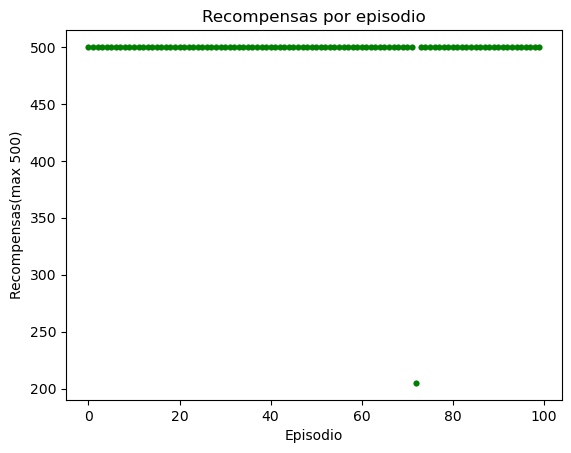

In [404]:

plot(range(tries), rewards, "Episodio", "Recompensas(max 500)", "Recompensas por episodio")